In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np

In [2]:
import urllib3, socket
from urllib3.connection import HTTPConnection
    
HTTPConnection.default_socket_options = ( 
            HTTPConnection.default_socket_options + [
            (socket.SOL_SOCKET, socket.SO_SNDBUF, 1000000), #1MB in byte
            (socket.SOL_SOCKET, socket.SO_RCVBUF, 1000000)
        ])


In [3]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id='40f6f26819784e3fa5c8dbeab0414a84',
                                                           client_secret='c944c475fcce4cd4b44f344149119f08'))

# Importing the spotify playlist

In [4]:
def get_playlist_tracks(playlist_id):
    results = sp.user_playlist_tracks("spotify",playlist_id)
    tracks = results['items']
    while results['next']!=None:
        results = sp.next(results)
        tracks = tracks + results['items']
        sleep(randint(1,3))
    return tracks

In [5]:
from random import randint
from time import sleep

In [6]:
all_tracks=get_playlist_tracks('1G8IpkZKobrIlXcVPoSIuf')

In [7]:
all_track1=get_playlist_tracks('4rnleEAOdmFAbRcNCgZMpY')

In [8]:
all_tracks=all_tracks+all_track1

In [9]:
len(all_tracks)

15295

# Creating a Dataframe of playlist

In [10]:
playlist = sp.user_playlist_tracks("spotify", "1G8IpkZKobrIlXcVPoSIuf")

song_name = []
artist_name = []
track_uri = []
for i in range(len(all_tracks)):
    try:
        song = all_tracks[i]['track']['name']
        artist = all_tracks[i]["track"]["album"]['artists'][0]['name']
        uri = all_tracks[i]['track']['uri']
        artist_name.append(artist)
        song_name.append(song)
        track_uri.append(uri)
    except:
        artist_name.append('none')
        song_name.append('none')
        track_uri.append('none')

spotify_df=pd.DataFrame({'song': song_name,'artist': artist_name,'uri': track_uri})

In [11]:
spotify_df.head()

,song,artist,uri
0,Like a Rolling Stone,Bob Dylan,spotify:track:3AhXZa8sUQht0UEdBJgpGc
1,Smells Like Teen Spirit,Nirvana,spotify:track:3oTlkzk1OtrhH8wBAduVEi
2,A Day In The Life - Remastered,The Beatles,spotify:track:3ZFBeIyP41HhnALjxWy1pR
3,Good Vibrations (Mono),The Beach Boys,spotify:track:5Qt4Cc66g24QWwGP3YYV9y
4,Johnny B Goode,Chuck Berry,spotify:track:7MH2ZclofPlTrZOkPzZKhK


In [12]:
spotify_df.shape

(15295, 3)

# Cleaning the Nan value and duplicates

In [13]:
spotify_df.isna().sum()

song      0
artist    0
uri       0
dtype: int64

In [14]:
spotify_df=spotify_df.dropna()

In [15]:
spotify_df=spotify_df.drop_duplicates(keep='first')

In [16]:
spotify_df=spotify_df.reset_index(drop=True)

# Using uri to get the audio features 

In [17]:
#audio_f = []

#for x in spotify_df['uri']:
 #   audio_f.append(sp.audio_features(x))


In [18]:
def uri_audio_features(uri):
    
    return sp.audio_features(uri)

In [19]:
spotify_df['uri']=spotify_df['uri'].apply(uri_audio_features)

In [20]:
spotify_df.head()

,song,artist,uri
0,Like a Rolling Stone,Bob Dylan,"[{'danceability': 0.482, 'energy': 0.721, 'key..."
1,Smells Like Teen Spirit,Nirvana,"[{'danceability': 0.485, 'energy': 0.863, 'key..."
2,A Day In The Life - Remastered,The Beatles,"[{'danceability': 0.364, 'energy': 0.457, 'key..."
3,Good Vibrations (Mono),The Beach Boys,"[{'danceability': 0.398, 'energy': 0.413, 'key..."
4,Johnny B Goode,Chuck Berry,"[{'danceability': 0.518, 'energy': 0.756, 'key..."


# Flattening the column

In [21]:
def flatten(data, col_list):
    for column in col_list:
        flattened = pd.DataFrame(dict(data[column])).transpose()
        columns = [str(col) for col in flattened.columns]
        flattened.columns = [column + '_' + colname for colname in columns]
        data = pd.concat([data, flattened], axis=1)
        data = data.drop(column, axis=1)
    return data


In [22]:
flat = flatten(spotify_df, ['uri'])
flat

,song,artist,uri_0
0,Like a Rolling Stone,Bob Dylan,"{'danceability': 0.482, 'energy': 0.721, 'key'..."
1,Smells Like Teen Spirit,Nirvana,"{'danceability': 0.485, 'energy': 0.863, 'key'..."
2,A Day In The Life - Remastered,The Beatles,"{'danceability': 0.364, 'energy': 0.457, 'key'..."
3,Good Vibrations (Mono),The Beach Boys,"{'danceability': 0.398, 'energy': 0.413, 'key'..."
4,Johnny B Goode,Chuck Berry,"{'danceability': 0.518, 'energy': 0.756, 'key'..."
...,...,...,...
15040,Hermit the Frog,MARINA,"{'danceability': 0.609, 'energy': 0.679, 'key'..."
15041,deja vu,Olivia Rodrigo,"{'danceability': 0.439, 'energy': 0.61, 'key':..."
15042,WHOLE LOTTA MONEY,BIA,"{'danceability': 0.897, 'energy': 0.371, 'key'..."
15043,Slumber Party (feat. Princess Nokia),Ashnikko,"{'danceability': 0.964, 'energy': 0.398, 'key'..."


In [23]:
flat1=flatten(flat, ['uri_0'])

In [24]:
data=flat1

In [25]:
data['uri_0_time_signature'].value_counts()

4    14095
3      763
5      121
1       64
0        1
Name: uri_0_time_signature, dtype: int64

# Renaming the columns

In [26]:
cols=[]
for i in range(len(data.columns)):
    cols.append(data.columns[i].lower().replace('uri_0_', ''))
data.columns = cols

print(data.columns)

Index(['song', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature'],
      dtype='object')


In [27]:
data=data.dropna()

In [28]:
data=data.reset_index(drop=True)

# Selecting the desired columns

In [29]:
data_num=data[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]

In [30]:
data_num.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.482,0.721,0,-6.839,1,0.0321,0.731,0,0.189,0.557,95.263
1,0.485,0.863,1,-9.027,1,0.0495,0.000012,0.0162,0.138,0.767,116.835
2,0.364,0.457,4,-14.162,0,0.0675,0.29,0.000106,0.922,0.175,163.219
3,0.398,0.413,1,-10.934,1,0.0388,0.0822,0.000025,0.0891,0.331,133.574
4,0.518,0.756,10,-10.851,1,0.0915,0.735,0.000062,0.317,0.968,166.429


In [31]:
data_num.isna().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
dtype: int64

# Converting the columns to numerical columns

In [32]:
for i in data_num.columns:
    data_num[i]=pd.to_numeric(data_num[i],errors='coerce')

C:\Users\Admin\AppData\Local\Temp\ipykernel_4000\916430225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_num[i]=pd.to_numeric(data_num[i],errors='coerce')


In [33]:
data_num.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,15044.0,0.598905,0.163488,0.00000,0.4910,0.609000,0.716000,0.988
energy,15044.0,0.644733,0.216971,0.00002,0.5030,0.680000,0.816000,1.000
key,15044.0,5.278516,3.574387,0.00000,2.0000,5.000000,8.000000,11.000
loudness,15044.0,-8.125726,3.737479,-60.00000,-10.2505,-7.307500,-5.373750,1.342
mode,15044.0,0.653350,0.475919,0.00000,0.0000,1.000000,1.000000,1.000
speechiness,15044.0,0.081739,0.084345,0.00000,0.0349,0.047800,0.085325,0.934
acousticness,15044.0,0.255326,0.297586,0.00000,0.0207,0.117000,0.414000,0.996
instrumentalness,15044.0,0.078898,0.211064,0.00000,0.0000,0.000041,0.007168,0.993
liveness,15044.0,0.188887,0.149894,0.00829,0.0931,0.129000,0.247000,0.993
valence,15044.0,0.555951,0.241955,0.00000,0.3670,0.564000,0.754000,1.000


In [34]:
data_num.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.482,0.721,0,-6.839,1,0.0321,0.731000,0.000000,0.1890,0.557,95.263
1,0.485,0.863,1,-9.027,1,0.0495,0.000012,0.016200,0.1380,0.767,116.835
2,0.364,0.457,4,-14.162,0,0.0675,0.290000,0.000106,0.9220,0.175,163.219
3,0.398,0.413,1,-10.934,1,0.0388,0.082200,0.000025,0.0891,0.331,133.574
4,0.518,0.756,10,-10.851,1,0.0915,0.735000,0.000062,0.3170,0.968,166.429


# Scaling the columns

In [111]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
transformer=StandardScaler().fit(data_num)
x_prep = transformer.transform(data_num)
X_prep= pd.DataFrame(x_prep,columns=data_num.columns)
#transformer = MinMaxScaler().fit(data_num)
#X = transformer.transform(data_num)
#X_prep = pd.DataFrame(X, columns=data_num.columns)
#X_prep.head()

In [112]:
X_prep.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,-0.715092,0.351518,-1.476810,0.344288,0.728404,-0.588541,1.598493,-0.373825,0.000757,0.004337,-0.959960
1,-0.696741,1.006005,-1.197033,-0.241153,0.728404,-0.382240,-0.857976,-0.297068,-0.339495,0.872296,-0.174908
2,-1.436880,-0.865275,-0.357700,-1.615119,-1.372864,-0.168824,0.116522,-0.373322,4.891042,-1.574523,1.513107
3,-1.228907,-1.068074,-1.197033,-0.751407,0.728404,-0.509103,-0.581786,-0.373704,-0.665737,-0.929753,0.434261
4,-0.494885,0.512835,1.320965,-0.729199,0.728404,0.115729,1.611935,-0.373531,0.854722,1.703057,1.629925


# Computing the optimal k value

In [198]:
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

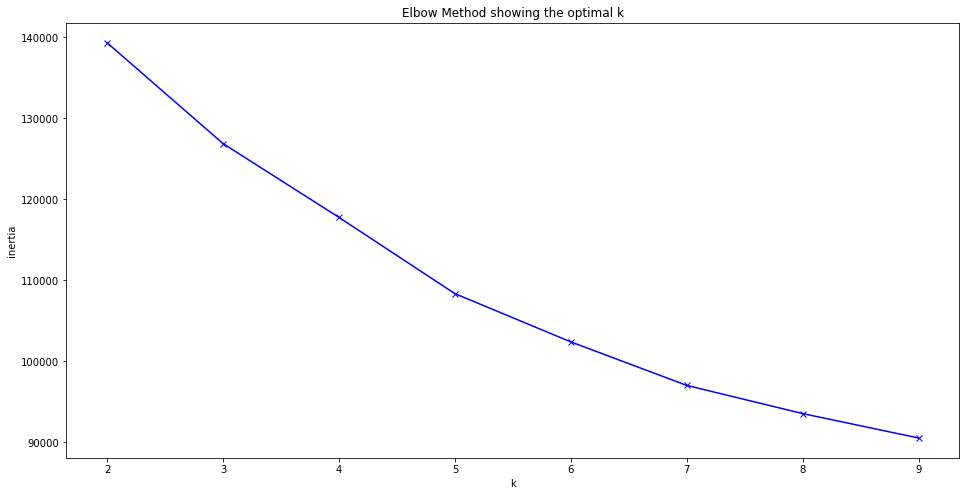

In [199]:
import numpy as np
K = range(2, 10)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

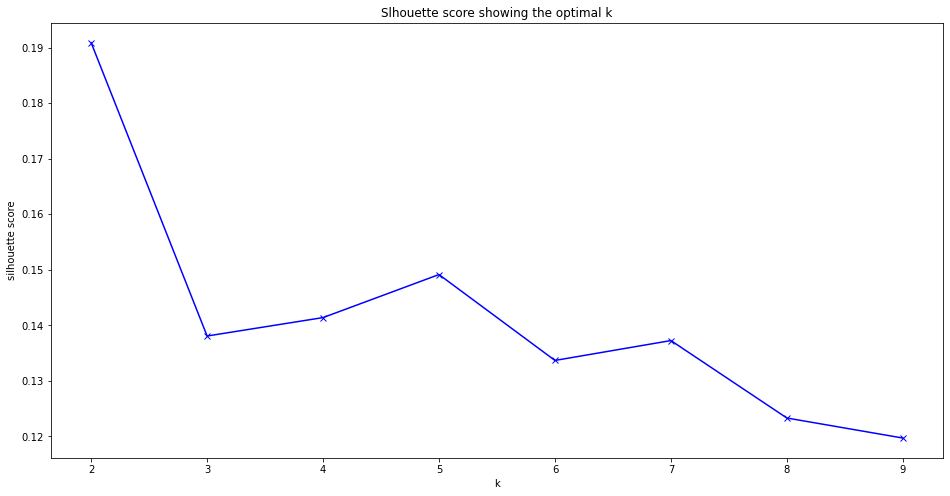

In [200]:
from sklearn.metrics import silhouette_score
K = range(2, 10)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

In [201]:
# In terms of the Elbow Method k=5 is optimal but according to the Slhouette score i should choose k=2. I am not sure which one is right.

# Creating the KMeans Model

In [202]:
kmeans = KMeans(n_clusters=5, random_state=1234)
kmeans.fit(X_prep)

KMeans(n_clusters=5, random_state=1234)

In [203]:
clusters = kmeans.predict(X_prep)

In [204]:
clusters

array([1, 1, 0, ..., 4, 2, 2])

# Creating a new column 'cluster' and add it to the original dataset

In [205]:
data['cluster']=pd.DataFrame(clusters,columns=['cluster'])

In [206]:
data.head()

,song,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,cluster
0,Like a Rolling Stone,Bob Dylan,0.482,0.721,0,-6.839,1,0.0321,0.731,0,...,0.557,95.263,audio_features,3AhXZa8sUQht0UEdBJgpGc,spotify:track:3AhXZa8sUQht0UEdBJgpGc,https://api.spotify.com/v1/tracks/3AhXZa8sUQht...,https://api.spotify.com/v1/audio-analysis/3AhX...,369600,4,1
1,Smells Like Teen Spirit,Nirvana,0.485,0.863,1,-9.027,1,0.0495,0.000012,0.0162,...,0.767,116.835,audio_features,3oTlkzk1OtrhH8wBAduVEi,spotify:track:3oTlkzk1OtrhH8wBAduVEi,https://api.spotify.com/v1/tracks/3oTlkzk1Otrh...,https://api.spotify.com/v1/audio-analysis/3oTl...,300977,4,1
2,A Day In The Life - Remastered,The Beatles,0.364,0.457,4,-14.162,0,0.0675,0.29,0.000106,...,0.175,163.219,audio_features,3ZFBeIyP41HhnALjxWy1pR,spotify:track:3ZFBeIyP41HhnALjxWy1pR,https://api.spotify.com/v1/tracks/3ZFBeIyP41Hh...,https://api.spotify.com/v1/audio-analysis/3ZFB...,337413,4,0
3,Good Vibrations (Mono),The Beach Boys,0.398,0.413,1,-10.934,1,0.0388,0.0822,0.000025,...,0.331,133.574,audio_features,5Qt4Cc66g24QWwGP3YYV9y,spotify:track:5Qt4Cc66g24QWwGP3YYV9y,https://api.spotify.com/v1/tracks/5Qt4Cc66g24Q...,https://api.spotify.com/v1/audio-analysis/5Qt4...,219147,4,0
4,Johnny B Goode,Chuck Berry,0.518,0.756,10,-10.851,1,0.0915,0.735,0.000062,...,0.968,166.429,audio_features,7MH2ZclofPlTrZOkPzZKhK,spotify:track:7MH2ZclofPlTrZOkPzZKhK,https://api.spotify.com/v1/tracks/7MH2ZclofPlT...,https://api.spotify.com/v1/audio-analysis/7MH2...,160893,4,1


In [207]:
#data.to_csv('data.csv')

# Defining a function to normalize the data and calculate cluster to which the song belongs

In [209]:
def scaling_data(uri):
    demo_music=pd.DataFrame(pd.DataFrame(sp.audio_features(uri)))
    demo_num=demo_music[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]
    for i in demo_num.columns:
        demo_num[i]=pd.to_numeric(demo_num[i],errors='coerce')
    demo_prep = transformer.transform(demo_num)
    demo_cluster=kmeans.predict(demo_prep)
    return demo_cluster

In [210]:
scaling_data(results['tracks']['items'][1]['uri'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_4000\2363950725.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_num[i]=pd.to_numeric(demo_num[i],errors='coerce')
D:\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


array([1])

In [ ]:
# I don't know why it prompts me a warning message.

# Get top 100 Songs list

In [120]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import random

In [52]:
url = "https://www.popvortex.com/music/charts/top-100-songs.php"

In [53]:
response = requests.get(url)
response.status_code
soup = BeautifulSoup(response.content, "html.parser")

In [54]:
title=[]
artist=[]
release_time=[]
genre=[]
num_iter = len(soup.select('div.chart-content.col-xs-12.col-sm-8 > p '))
for i in range(num_iter):
    title.append(soup.select("cite.title")[i].get_text())
    artist.append(soup.select('em.artist')[i].get_text())
   

In [55]:
music = pd.DataFrame({"title":title,
                       "artist":artist,      
                     })

In [189]:
#music.head()

# Creating the song recommender function

In [187]:
def song_recommend(): 
    k=1
    while(k):
        music_name=str(input("please import a song name:"))
        if music_name in music['title'].values:
            arbi=random.randint(0,len(music.index)-1)
            print('Our recommandation for you is:',music['title'][arbi],'singed by',music['artist'][arbi])
            if music['title'][arbi]==music_name:
                continue
            else:
                k=0
        else:
            results = sp.search(q=music_name)
            for i in range(len(results['tracks']['items'])):
                    print('Is the song you search:%s by %s'%(results['tracks']['items'][i]['name'],results['tracks']['items'][i]['artists'][0]['name']))
                    answer=str(input('please input Y or N:'))
                    if answer=='Y':
                        track=results['tracks']['items'][i]['uri']
                        result_cluster=scaling_data(track)
                        #print(result_cluster)
                        song_cluster=data
                        song_cluster_demo=song_cluster[(song_cluster['cluster'].isin(result_cluster))]
                        song_cluster_demo=song_cluster_demo.reset_index(drop=True)
                        #display(song_cluster_demo)
                        random_number=random.randint(0,len(song_cluster_demo.index)-1)
                        #print(random_number)
                        print('Our recommandation for you is:',song_cluster_demo['song'][random_number],'singed by',song_cluster_demo['artist'][random_number])
                        break
                    else:
                        continue
            k=0

In [188]:
song_recommend()

please import a song name:Da Da Da
Is the song you search:DA DA DANCE by BABYMETAL
please input Y or N:N
Is the song you search:Sunroof by Nicky Youre
please input Y or N:N
Is the song you search:Da Da Da I Don't Love You You Don't Love Me Aha Aha Aha by Trio
please input Y or N:Y


C:\Users\Admin\AppData\Local\Temp\ipykernel_4000\3029072592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_num[i]=pd.to_numeric(demo_num[i],errors='coerce')


Our recommandation for you is: Give Me All Your Luvin' singed by Madonna


D:\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
